# Final Random Forest Model

In this notebook I am going to implement and Random Forest Model on data using the hyperparameters which I tuned in the previous notebook `02_build_multiple_models.ipynb`

## Library Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

#misc libraries
import random
import time

# Disabling warnings:
import warnings
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')



#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))
import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))
import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 
import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
pandas version: 2.1.2
matplotlib version: 3.7.2
NumPy version: 1.24.3
IPython version: 8.15.0
scikit-learn version: 1.3.0
-------------------------


## Data load and pre-processing

In [2]:
# The repo which has the data
from ucimlrepo import fetch_ucirepo

In [3]:
# this function allows you read the data from remote repository or previously downloaded 
# copy from local folder
def read_data(local=True, local_file_name="diabetes_raw_data.csv"):
    """Reads the raw dataset from either local csv file or from UCI repository

    Args:
        local (bool, optional): Indicator for local file or remote. Defaults to True.

    Returns:
        _type_: A DataFrame containing data read from local or remote csv file
    """
    if local:
        return pd.read_csv(local_file_name)
    else:
        # fetch dataset from UCI
        cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
        
        # data (as pandas dataframes) 
        X = cdc_diabetes_health_indicators.data.features 
        y = cdc_diabetes_health_indicators.data.targets 
        # Lets join the features and target variable into a single data frame
        return pd.concat([X,y],axis=1)

In [4]:
# read the data from remote repo
# df = read_data(local=False, local_file_name=None)

# saving this data so I don't keep downloading from UCI
# df.to_csv("diabetes_raw_data.csv",index=False)

# read the dataset from previously downloaded file - which I named "diabetes_raw_data.csv"
df_raw = read_data(local=True, local_file_name="diabetes_raw_data.csv")

In [5]:
# Now remove duplicated records
df = df_raw.copy().drop_duplicates(keep= 'first', ignore_index=True)

In [6]:
# Remap encoded categorical features into Strings
# Re map the categorical data which will then be encoded using dummies etc

# Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional
# 0 = no high BP 1 = high BP
df["HighBP"] = df["HighBP"].map({0 : 'no', 1 : 'yes'})
# Have you EVER been told by a doctor, nurse or other health professional that your blood cholesterol is high?

df["HighChol"] = df["HighChol"].map({0 : 'no', 1 : 'yes'})

# Cholesterol check within past five years 
df["CholCheck"] = df["CholCheck"].map({0 : 'no', 1 : 'yes'})

# Have you smoked at least 100 cigarettes in your entire life?
df["Smoker"] = df["Smoker"].map({0:'no', 1:'yes'})

# (Ever told) you had a stroke. 0 = no 1 = yes
df["Stroke"] = df["Stroke"].map({0 : 'no', 1:'yes'})

# coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes
df["HeartDiseaseorAttack"] = df["HeartDiseaseorAttack"].map({0:'no', 1:'yes'})

# physical activity in past 30 days - not including job 0 = no 1 = yes
df["PhysActivity"] = df["PhysActivity"].map({0:'no', 1:'yes'})

# Consume Fruit 1 or more times per day 0 = no 1 = yes
df["Fruits"] = df["Fruits"].map({0:'no', 1:'yes'})

# Consume Vegetables 1 or more times per day 0 = no 1 = yes
df["Veggies"] = df["Veggies"].map({0:'no', 1:'yes'})

# Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes
df["HvyAlcoholConsump"] = df["HvyAlcoholConsump"].map({0:'no', 1:'yes'})

# Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes
df["AnyHealthcare"] = df["AnyHealthcare"].map({0:'no', 1:'yes'})

# Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes
df["NoDocbcCost"] = df["NoDocbcCost"].map({0:'no', 1:'yes'})

# Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor
df["GenHlth"] = df["GenHlth"].map({1:'excellent', 2:'very_good', 3:'good', 4:'fair', 5:'poor'})

# Now thinking about your mental health, which includes stress, depression, and problems with emotions, 
# for how many days during the past 30 days was your mental health not good? scale 1-30 days
################df["MentHlth"] = df["MentHlth"].map({})
# Now thinking about your physical health, which includes physical illness and injury, 
# for how many days during the past 30 days was your physical health not good? scale 1-30 days
###############df["PhysHlth"] = df["PhysHlth"].map({})

# Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes
df["DiffWalk"] = df["DiffWalk"].map({0:'no', 1:'yes'})

# Gender of the person
df["Sex"] = df["Sex"].map({0:'female', 1:'male'})

#https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/discussion/295407
# 13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older
df["Age"] = df["Age"].map({1:'18_24', 2:'25_29',3:  '30_34',4:'35_39',5:'40_44',6:'45_49',
                                   7:'50_54',8:'55_59',9:'60_64',10:'65_69',11:'70_74',12:'75_79',13:'80_'})

# What is the highest grade or year of school you completed? = EDUCA
# 1 = Never attended school or only kindergarten 
# 2 = Grades 1 through 8 (Elementary) 
# 3 = Grades 9 through 11 (Some high school) 
# 4 = Grade 12 or GED (High school graduate) 
# 5 = College 1 year to 3 years (Some college or technical school) 
# 6 = College 4 years or more (College graduate)
df["Education"] = df["Education"].map({1:"uneducated",
                                        2:"elementary",
                                        3:"some_high_school",
                                        4:"high_school_graduate",
                                        5:"some_college",
                                        6:"college_graduate"})

# Income scale (INCOME2 see codebook)
df["Income"] = df["Income"].map({1:"LT10k",
                                  2:"10k_15k",
                                  3:"15k_20k",
                                  4:"20k_25k",
                                  5:"25k_35k",
                                  6:"35k_50k",
                                  7:"50k_75k",
                                  8:"GT75k"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229474 entries, 0 to 229473
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   HighBP                229474 non-null  object
 1   HighChol              229474 non-null  object
 2   CholCheck             229474 non-null  object
 3   BMI                   229474 non-null  int64 
 4   Smoker                229474 non-null  object
 5   Stroke                229474 non-null  object
 6   HeartDiseaseorAttack  229474 non-null  object
 7   PhysActivity          229474 non-null  object
 8   Fruits                229474 non-null  object
 9   Veggies               229474 non-null  object
 10  HvyAlcoholConsump     229474 non-null  object
 11  AnyHealthcare         229474 non-null  object
 12  NoDocbcCost           229474 non-null  object
 13  GenHlth               229474 non-null  object
 14  MentHlth              229474 non-null  int64 
 15  PhysHlth         

## Modeling

In [8]:
# Seeding:
def seed_all(seed):
    
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42    
seed_all(seed)

In [9]:
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, learning_curve,  cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

#import scikitplot as skplt

from yellowbrick.model_selection import validation_curve

### Remove Outliers using Isoltion Forest Model

In [10]:
numericals = ['BMI','MentHlth', 'PhysHlth']
categoricals = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
target = "Diabetes_binary"

In [11]:
def convert_to_dv(data, target):
    """coverts the given data frame into vectorized version

    Args:
        data (Pandas data frame): inout data farme
        target (str): Target Variable

    Returns:
        Tuple: returns  the new data frame and DV object
    """
    
    dF_lcoal = data.copy()
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.
    x_dicts = X.to_dict(orient='records')
    # I choose sparse = False becasue I got warnings about sparse = True
    dv = DictVectorizer(sparse=False,separator='_')
    # Apply DV on features
    X_dv = dv.fit_transform(x_dicts)
    
    # create data frame 
    df_transformed = pd.DataFrame(X_dv, columns =dv.get_feature_names_out())
    
    #add target back
    df_transformed[target] = y
    
    # return the new data frame
    return (dv, df_transformed)
    

In [12]:
dv, df_dv = convert_to_dv(df, target)

In [13]:
# Remember to save this in pickled file for later use
dv

DictVectorizer(separator='_', sparse=False)

In [14]:
# Applying Isolation Forest:
def remove_outliers(data, target):
    """Removes outliers from the given data frame using isolation forest model

    Args:
        data (Pandas DataFrame): The Data Frame
        target (str, optional): Name of traget variable.

    Returns:
        Pandas DataFrame: A data frame with outliers removed from it.
    """
    # Making a local copy so that I don't accidently overwrite original data frame
    df_local = data.copy()
    
    # Split the data into features and target
    X = df_local.drop(target, axis=1)
    y = df_local[target]
    
    # Initialise the model
    iForest = IsolationForest(contamination=0.1,random_state=seed)
    
    # Fit the isolation forect on X
    y_pred = iForest.fit_predict(X)
    
    # filter for outliers
    mask = (y_pred != -1)
    
    # remove those outliers
    X_clean = X.loc[mask, :]
    y_clean= y[mask]
    
    # return new data frame
    return pd.concat([X,y],axis=1)

In [15]:
df_cleaned = remove_outliers( data=df_dv, target='Diabetes_binary')

In [16]:
print("After removing {0} outliers, we are left with {1} records".format((len(df_dv)- len(df_cleaned)), len(df_cleaned)))  

After removing 0 outliers, we are left with 229474 records


In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229474 entries, 0 to 229473
Data columns (total 64 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Age_18_24                       229474 non-null  float64
 1   Age_25_29                       229474 non-null  float64
 2   Age_30_34                       229474 non-null  float64
 3   Age_35_39                       229474 non-null  float64
 4   Age_40_44                       229474 non-null  float64
 5   Age_45_49                       229474 non-null  float64
 6   Age_50_54                       229474 non-null  float64
 7   Age_55_59                       229474 non-null  float64
 8   Age_60_64                       229474 non-null  float64
 9   Age_65_69                       229474 non-null  float64
 10  Age_70_74                       229474 non-null  float64
 11  Age_75_79                       229474 non-null  float64
 12  Age_80_         

### Random Forest Model

The hyper parameters of this model came from previous notebook

- `n_estimators: 90`
-  `max_depth: 15`
- `bootstrap': False`

In [18]:
#Split the data into 2 parts: train/test with 70%/30% distribution. 
# Use train_test_split function for that with random_state=1

df_full_train, df_test = train_test_split(df_cleaned, test_size=0.3, random_state=seed)

print (len(df_full_train), len(df_test))

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

160631 68843


In [19]:
def train_rf_model(df_train, target):
    """Trains a Random Forest Model on data

    Args:
        df_train (DataFrame): Training dataset
        target (str): The target varaible
        
    Returns:
        Model: Object of Random Forest Model
    """
    
    # Get features and target
    X = df_train.drop(target, axis=1)
    y = df_train[target]
    

    model = randfclass = RandomForestClassifier(n_estimators= 90, 
                                    max_depth= 15, 
                                    bootstrap= False,
                                    random_state=seed,
                                    n_jobs=-1)
    model.fit(X, y)
    
    return model

In [20]:
def predict_diabetes(df_test, model):  
    """Returns prabilites of getting diabetes

    Args:
        df_test (_type_): _description_
        model (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    # Get features and target
    X = df_test.drop(target, axis=1)
    y = df_test[target]
    
    # Get prob of 1
    probabilities = model.predict_proba(X)
    

    # 2. Extract probabilities of class 0 and class 1.
    prob_class_0 = probabilities[:, 0]
    prob_class_1 = probabilities[:, 1]
    
    #return predictions
    return (prob_class_0, prob_class_1)

 Fit the model on training set

In [21]:
rf_model = train_rf_model(df_full_train,target)

Test the model to get probabilities

In [22]:
prob_class_0, prob_class_1 = predict_diabetes(df_test, rf_model)

In [23]:
# Calculate ROC curve: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(df_test[target], prob_class_1)

# Calculate Youden's index
J = tpr - fpr

# Find the threshold for the max value of Youden's index
optimal_threshold = thresholds[J.argmax()]

print(f"Optimal Threshold based on Youden's index: {optimal_threshold}")

# Generate predictions based on the optimal threshold
y_pred_optimal = [1 if p >= optimal_threshold else 0 for p in prob_class_1]

Optimal Threshold based on Youden's index: 0.14944631791961446


In [24]:
auc = roc_auc_score(df_test[target], y_pred_optimal)
print(f"AUC: {auc * 100:.2f}%")

AUC: 73.17%


In [25]:
print("\nClassification Report:")
print(classification_report(df_test[target], y_pred_optimal))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     58250
           1       0.31      0.78      0.44     10593

    accuracy                           0.70     68843
   macro avg       0.63      0.73      0.62     68843
weighted avg       0.85      0.70      0.74     68843



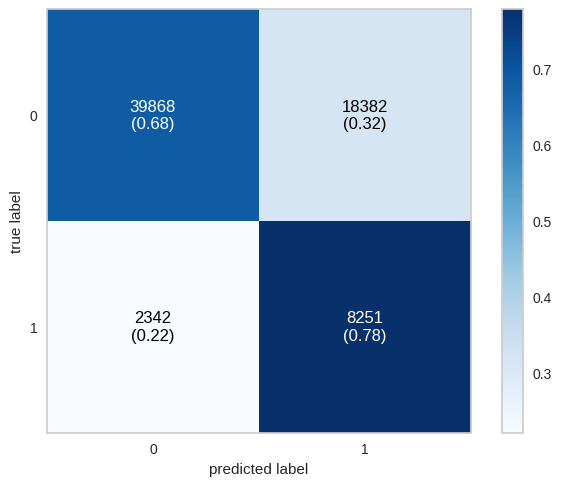

In [26]:
cm1 = confusion_matrix(df_test[target],y_pred_optimal)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,show_normed=True,colorbar=True)
plt.show()

## Save The model for offline use

In [27]:
rf_model

RandomForestClassifier(bootstrap=False, max_depth=15, n_estimators=90,
                       n_jobs=-1, random_state=42)

In [28]:
dv

DictVectorizer(separator='_', sparse=False)

In [31]:
ls -al /models

ls: cannot access '/models': No such file or directory


In [32]:
from joblib import dump

# Save the model to a file
dump(rf_model, 'models/rf_modelv1.joblib')
dump(dv, 'models/dv.joblib')

['models/dv.joblib']

In [ ]:
# To Load data back from file

from joblib import load

# Load the model from the file
#loaded_model = load('rf_modelv1.joblib')

# Use the loaded model to make predictions
#predictions = loaded_model.predict(X_test_reduced)

In [33]:
# Also save model using Pickly
import pickle

In [34]:
with open('models/rf_modelv1_pkl.bin', 'wb') as f_out: # 'wb' means write-binary
    pickle.dump(rf_model, f_out)
    
with open('models/dv_pkl.bin', 'wb') as f_out: # 'wb' means write-binary
    pickle.dump(dv, f_out)

In [ ]:
# To read pickle back
import pickle

#with open('mode.bin', 'rb') as f_in: # very important to use 'rb' here, it means read-binary 
#    dict_vectorizer, model = pickle.load(f_in)
## Note: never open a binary file you do not trust the source!